# 0. Setup

In [29]:
from abc import ABC, abstractmethod
import logging
import os

import numpy as np
import scipy.sparse as sp
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import ipyplot
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder

url_pattern = "http://images.amazon.com/images/P/ASIN.01._SCLZZZZZZZ_.jpg"

project_root = os.getcwd()
print(f"Project root: {project_root}")

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

MAX_IMAGES = 10
MAX_IMAGES_REC = 40
IMG_WIDTH = 150

Project root: /Users/masp/codes/sansa/examples


# 1. Dataset

In [30]:
# download Amazon Book dataset
dataset_path = "datasets/data/amazonbook"
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# uncommend below to download Amazon Book dataset (https://github.com/kuandeng/LightGCN/tree/master/Data/amazon-book)
# os.chdir("/".join([project_root, dataset_path]))
# !wget https://raw.githubusercontent.com/kuandeng/LightGCN/master/Data/amazon-book/item_list.txt
# !wget https://raw.githubusercontent.com/kuandeng/LightGCN/master/Data/amazon-book/test.txt
# !wget https://raw.githubusercontent.com/kuandeng/LightGCN/master/Data/amazon-book/train.txt
# !wget https://raw.githubusercontent.com/kuandeng/LightGCN/master/Data/amazon-book/user_list.txt
# os.chdir(project_root)

In [31]:
# classes for dataset and dataset split


class DatasetSplit:
    """Class for storing and manipulating implicit feedback data."""

    def __init__(
        self,
        df: pd.DataFrame,
        item_encoder: LabelEncoder,
        extract_targets: bool = False,
        target_proportion: float = 0.2,
        newest: bool = True,
    ) -> None:
        # Fit user encoder and transform user IDs.
        pd.options.mode.chained_assignment = None  # suppress irrelevant warning
        self.user_encoder = LabelEncoder()
        df.user_id = self.user_encoder.fit_transform(df.user_id.values)
        pd.options.mode.chained_assignment = "warn"  # reset to default

        self.item_encoder = item_encoder
        self.data, self.targets = extract_targets_from_split(
            df=df,
            extract_targets=extract_targets,
            target_proportion=target_proportion,
            newest=newest,
        )
        self.n_users = len(self.user_encoder.classes_)
        self.n_items = len(self.item_encoder.classes_)
        self.n_ratings = self.data.shape[0]

    @property
    def shape(self) -> tuple[int, int]:
        """Return the shape of the dataset."""
        return (self.n_users, self.n_items)

    @property
    def sparsity(self) -> float:
        """Return the sparsity of the dataset."""
        if (self.n_users == 0) or (self.n_items == 0):
            return 0
        return 1 - self.n_ratings / (self.n_users * self.n_items)

    @property
    def density(self) -> float:
        """Return the density of the dataset."""
        return 1 - self.sparsity

    def get_csr_matrix(self) -> sp.csr_matrix:
        df = self.data
        return df_to_csr(df=df, shape=(self.n_users, self.n_items))

    def get_csc_t_matrix(self) -> sp.csr_matrix:
        return self.get_csr_matrix().T

    def get_rated_items(self, user_ids: list[int]) -> pd.DataFrame:
        user_ids = self.user_encoder.transform(user_ids)
        rated_items_df = self.data[self.data.user_id.isin(user_ids)]

        return rated_items_df

    def get_target_items(self, user_ids: list[int]) -> pd.DataFrame:
        user_ids = self.user_encoder.transform(user_ids)
        targets_df = self.targets[self.targets.user_id.isin(user_ids)]

        return targets_df

    def info(self) -> str:
        return f"n_users = {self.n_users}, n_items = {self.n_items}, n_ratings = {self.n_ratings}, sparsity = {self.sparsity:.2%}"

    def item_item_info(self) -> str:
        return f"shape = ({self.n_items},{self.n_items})"

    def save(self, path: str) -> None:
        """Saves dataset split to pickle"""
        with open(path, "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, path: str) -> "DatasetSplit":
        """Loads dataset split from pickle"""
        with open(path, "rb") as f:
            return pickle.load(f)


class Dataset(ABC):
    def __init__(
        self,
        name: str,
        folder: str = "./data",
        processed_file: str = "ratings.parquet",
    ):
        self.name = name
        self.folder = folder
        self.processed_file = processed_file

        self.path = os.path.join(self.folder, self.name)
        self.dataset: pd.DataFrame = None
        self.processed: bool = False

    def _read_raw_data(self) -> None:
        """
        Loads raw data and stores it in self.dataset.
        """
        ...

    @abstractmethod
    def _unify_dataset(self) -> None:
        """
        Unifies the dataset to a common format.
        A common format is a dataframe with the following columns:
        - user_id: int64
        - item_id: int64
        - feedback: float64
        - timestamp: datetime64
        """
        ...

    @abstractmethod
    def _preprocess_data(self) -> None:
        """
        Preprocesses the dataset according to the experiment requirements.
        Sets self.preprocessed = True if the dataset was successfully preprocessed.
        """
        ...

    def save_processed(self) -> None:
        self.dataset.to_parquet(f"{self.path}/{self.processed_file}", index=False)

    def load_processed(self) -> None:
        """
        Load a processed dataset from a parquet file.
        """
        logger.info(f"Loading processed dataset {self.path}/{self.processed_file}.")
        self.dataset = pd.read_parquet(f"{self.path}/{self.processed_file}")
        self.processed = True

    def preprocess_and_save(self) -> None:
        logger.info(f"Creating new dataset {self.name}:")
        logger.info(f"Loading raw dataset files from {self.path}/ ...")
        self._read_raw_data()
        logger.info("Unifying dataset format...")
        self._unify_dataset()
        logger.info("Preprocessing dataset...")
        self._preprocess_data()
        logger.info(f"Saving processed dataset {self.path}/{self.processed_file}...")
        self.save_processed()

    @classmethod
    def from_config(cls, config: dict) -> "Dataset":
        """Instantiate a dataset according to the config."""
        # Get config parameters.
        dataset_name = config["name"]  # must be specified
        folder = config.get("folder", "datasets/data")

        # Instantiate dataset.
        processed_file = "dataset.parquet"
        dataset = cls(
            name=dataset_name,
            folder=folder,
            processed_file=processed_file,
        )

        # Check if processed dataset is available and rewrite is not requested.
        f = os.path.join(dataset.path, dataset.processed_file)
        if os.path.isfile(f) and not config.get("rewrite", False):
            dataset.load_processed()
            return dataset

        # Preprocess raw data and save dataset.
        dataset.preprocess_and_save()
        return dataset

    def create_splits(self, config: dict) -> tuple[DatasetSplit, DatasetSplit, DatasetSplit]:
        """
        Creates train, validation and test split objects from the dataset.
        Split is done horizontally, i.e. users are split into train, validation and test users.
        Targets are extracted from validation and test users, train users only if needed (e.g. EASE-like models do not need train targets).
        """
        # To continue, the dataset must be processed.
        if not self.processed:
            raise ValueError("Dataset not processed yet.")

        # Get config parameters.
        n_val_users = config.get("n_val_users", 10000)
        n_test_users = config.get("n_test_users", 10000)
        test_target_proportion = config["target_proportion"]  # must be specified
        val_target_proportion = config.get("val_target_proportion", test_target_proportion)
        train_target_proportion = config.get("train_target_proportion", test_target_proportion)
        newest = config.get("targets_newest", False)
        seed = config.get("seed", 42)
        extract_train_targets = config.get("extract_train_targets", False)

        # Fit item encoder and transform item IDs.
        item_encoder = LabelEncoder().fit(self.dataset["item_id"])
        self.dataset["item_id"] = item_encoder.transform(self.dataset["item_id"])

        # Shuffle dataset.
        self.dataset = self.dataset.sample(frac=1, random_state=seed)

        # Split dataset.
        train_df, val_df, test_df = horizontal_split(self.dataset, n_val_users, n_test_users, seed)

        # Log split information.
        logger.info(f"Dataframe lengths | train_df: {len(train_df)}, val_df: {len(val_df)}, test_df: {len(test_df)}")

        # Create split objects.
        train_split = DatasetSplit(
            train_df,
            item_encoder,
            extract_targets=extract_train_targets,
            target_proportion=train_target_proportion,  # only used if extract_targets
            newest=newest,  # only used if extract_targets
        )
        val_split = DatasetSplit(
            val_df,
            item_encoder,
            extract_targets=True,
            target_proportion=val_target_proportion,
            newest=newest,
        )
        test_split = DatasetSplit(
            test_df,
            item_encoder,
            extract_targets=True,
            target_proportion=test_target_proportion,
            newest=newest,
        )

        # Log dataset information.
        logger.info(msg="Splits information:")
        logger.info(msg=f"Train split info | {train_split.info()}")
        logger.info(msg=f"Validation split info | {val_split.info()}")
        logger.info(msg=f"Test split info | {test_split.info()}")

        return train_split, val_split, test_split

    def info(self) -> dict | None:
        """
        Returns dict of information about the dataset.
        """
        dataset_name_str = f"Dataset: {self.name}\n"
        if self.dataset is None:
            logger.warning(dataset_name_str + "Not loaded yet.")
            return None
        num_users = self.dataset.user_id.nunique()
        num_items = self.dataset.item_id.nunique()

        info_dict = {
            "Dataset name": self.name,
            "Number of users": num_users,
            "Number of items": num_items,
            "Number of interactions": len(self.dataset),
            "Interaction density": f"{len(self.dataset) / (num_users * num_items):.4%}",
        }

        return info_dict


def df_to_csr(df: pd.DataFrame, shape: tuple[int, int]) -> sp.csr_matrix:
    """Returns a sparse matrix from a dataframe."""
    return sp.coo_matrix(
        (df.feedback, (df.user_id, df.item_id)),
        shape=shape,
        dtype=np.float64,
    ).tocsr()


def extract_targets_from_split(
    df: pd.DataFrame,
    extract_targets: bool,
    target_proportion: float = 0.2,
    newest: bool = True,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Extracts targets from a (horizontal) split of a dataframe."""
    if not extract_targets:
        return df, None
    tmp_df = df.copy()
    if newest:
        tmp_df.sort_values(by=["timestamp"], ascending=[False], inplace=True)
    user_rating_counts = tmp_df["user_id"].value_counts()
    target_sizes = np.floor(target_proportion * user_rating_counts).astype(int)
    user_id_groups = tmp_df.groupby("user_id", group_keys=True)
    inputs_df = user_id_groups.apply(lambda x: x[target_sizes[x.name] :]).reset_index(drop=True)
    target_df = user_id_groups.apply(lambda x: x[: target_sizes[x.name]]).reset_index(drop=True)
    return inputs_df, target_df


def extract_marked_targets_from_split(
    df: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Extracts marked targets from a split of a dataframe."""
    tmp_df = df.copy()
    inputs_df = tmp_df[~tmp_df["target"]]
    target_df = tmp_df[tmp_df["target"]]
    return inputs_df, target_df


class FixedVerticalDatasetSplit(DatasetSplit):
    """
    Class preserving fixed splits, for storing and manipulating implicit feedback data.
    """

    def __init__(
        self,
        df: pd.DataFrame,
        item_encoder: LabelEncoder,
    ) -> None:
        self.item_encoder = item_encoder
        # df has column "target" with 1 if item is target, 0 otherwise
        self.data, self.targets = extract_marked_targets_from_split(df=df)

        # Find users with empty targets and remove them from data.
        users_with_empty_targets = list(set(self.data.user_id) - set(self.targets.user_id))
        logger.info(f"Removing users {users_with_empty_targets} from test inputs.")
        self.data = self.data[self.data.user_id.isin(self.targets.user_id)]
        # Fit user encoder and transform user IDs.
        pd.options.mode.chained_assignment = None  # suppress irrelevant warning
        self.user_encoder = LabelEncoder()
        self.data.user_id = self.user_encoder.fit_transform(self.data.user_id.values)
        self.targets.user_id = self.user_encoder.transform(self.targets.user_id.values)
        pd.options.mode.chained_assignment = "warn"  # reset to default

        self.data.drop(columns=["target"], inplace=True)
        self.targets.drop(columns=["target"], inplace=True)

        self.n_users = len(self.user_encoder.classes_)
        self.n_items = len(self.item_encoder.classes_)
        self.n_ratings = self.data.shape[0]


def horizontal_split(
    df: pd.DataFrame,
    n_val_users: int,
    n_test_users: int,
    seed: int,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Splits a dataframe horizontally (=disjoint user sets) into train, validation, and test sets."""
    np.random.seed(seed)
    unique_users = df["user_id"].unique()
    np.random.shuffle(unique_users)
    test_users = unique_users[:n_test_users]
    val_users = unique_users[n_test_users : n_test_users + n_val_users]
    train_users = unique_users[n_test_users + n_val_users :]
    train_df = df[df["user_id"].isin(train_users)]
    val_df = df[df["user_id"].isin(val_users)]
    test_df = df[df["user_id"].isin(test_users)]
    return train_df, val_df, test_df


def fixed_vertical_split(
    df: pd.DataFrame,
    val_target_proportion: float,
    seed: int,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Splits a dataframe according to predefined train and test sets. Creates train, validation, and test dataframes."""
    np.random.seed(seed)
    # df has column "target", used to identify test targets
    val_inputs_df, val_targets_df = extract_targets_from_split(
        df=df[~df["target"]],
        extract_targets=True,
        target_proportion=val_target_proportion,
        newest=False,
    )
    val_inputs_df.drop(columns=["target"], inplace=True)
    val_targets_df.drop(columns=["target"], inplace=True)
    val_df = pd.concat([val_inputs_df, val_targets_df])
    train_df = val_inputs_df
    return train_df, val_df, df


class Amazonbook(Dataset):
    def _read_raw_data(self) -> None:
        """
        Loads raw data and stores it in self.dataset.
        """
        train_file = f"{self.path}/train.txt"
        test_file = f"{self.path}/test.txt"

        # Selected train interactions
        users_train = []
        items_train = []
        target_train = []
        if not os.path.isfile(train_file):
            raise ValueError(f"Train file {train_file} not found.")
        with open(train_file) as f:
            lines = f.read().splitlines()
        for line in lines:
            entries = line.split()
            user = entries[0]
            items = entries[1:]
            users_train += [user] * len(items)
            items_train += items
            target_train += [False] * len(items)

        # Selected targets
        users_test = []
        items_test = []
        target_test = []
        if not os.path.isfile(test_file):
            raise ValueError(f"Test file {test_file} not found.")
        with open(test_file) as f:
            lines = f.read().splitlines()
        for line in lines:
            entries = line.split()
            user = entries[0]
            items = entries[1:]
            users_test += [user] * len(items)
            items_test += items
            target_test += [True] * len(items)

        train_dataset = pd.DataFrame(
            {
                "user_id": users_train,
                "item_id": items_train,
                "feedback": [1] * len(items_train),
                "timestamp": [0] * len(items_train),
                "target": target_train,
            }
        )
        test_dataset = pd.DataFrame(
            {
                "user_id": users_test,
                "item_id": items_test,
                "feedback": [1] * len(items_test),
                "timestamp": [0] * len(items_test),
                "target": target_test,
            }
        )

        self.dataset = pd.concat([train_dataset, test_dataset], ignore_index=True)

    def _unify_dataset(self) -> None:
        """
        Unifies the dataset to a common format.
        A common format is a dataframe with the following columns:
        - user_id: int64
        - item_id: int64
        - feedback: float64
        - timestamp: datetime64
        - target: bool      # specific for datasets with fixed targets
        """
        # Change user_id and item_id to int64
        self.dataset.user_id = self.dataset.user_id.astype(np.int64)
        self.dataset.item_id = self.dataset.item_id.astype(np.int64)
        # Change feedback to float64
        self.dataset.feedback = self.dataset.feedback.astype(np.float64)
        # Change timestamp to datetime
        self.dataset.timestamp = pd.to_datetime(self.dataset.timestamp)

    def _preprocess_data(self) -> None:
        """
        Preprocesses the dataset according to the experiment requirements.
        Returns True if the dataset was successfully preprocessed.
        """
        # Set self.processed to True to indicate that the dataset was successfully preprocessed
        self.processed = True

    def create_splits(self, config: dict) -> tuple[DatasetSplit, DatasetSplit, FixedVerticalDatasetSplit]:
        """
        Creates train, validation and test split objects from the dataset.
        Split is done VERTICALLY, using pre-defined interactions for test.
        """
        # To continue, the dataset must be processed.
        if not self.processed:
            raise ValueError("Dataset not processed yet.")

        # Get config parameters (all are optional).
        train_target_proportion = config.get("train_target_proportion", 0.1)
        val_target_proportion = config.get("val_target_proportion", 0.1)
        seed = config.get("seed", 42)
        extract_train_targets = config.get("extract_train_targets", False)

        # Fit item encoder and transform item IDs.
        item_encoder = LabelEncoder().fit(self.dataset["item_id"])
        self.dataset["item_id"] = item_encoder.transform(self.dataset["item_id"])

        # Shuffle dataset.
        self.dataset = self.dataset.sample(frac=1, random_state=seed)

        # Split dataset.
        train_df, val_df, test_df = fixed_vertical_split(self.dataset, val_target_proportion, seed)

        # Log dataset information.
        logger.info(f"Dataframe lengths | train_df: {len(train_df)}, val_df: {len(val_df)}, test_df: {len(test_df)}")

        # Create split objects (test split is fixed)
        train_split = DatasetSplit(
            train_df,
            item_encoder,
            extract_targets=extract_train_targets,
            target_proportion=train_target_proportion,  # only used if extract_targets
            newest=False,
        )
        val_split = DatasetSplit(
            val_df,
            item_encoder,
            extract_targets=True,
            target_proportion=val_target_proportion,
            newest=False,
        )
        test_split = FixedVerticalDatasetSplit(
            test_df,
            item_encoder,
        )

        return train_split, val_split, test_split

Downloaded Amazon Books dataset.
Dataset info:
{'Dataset name': 'amazonbook', 'Number of users': 52643, 'Number of items': 91599, 'Number of interactions': 2984108, 'Interaction density': '0.0619%'}

Item distribution
count    91599.000000
mean        32.577954
std         45.273947
min         10.000000
25%         13.000000
50%         19.000000
75%         35.000000
95%         94.000000
99.9%      551.000000
max       1907.000000
Name: count, dtype: float64


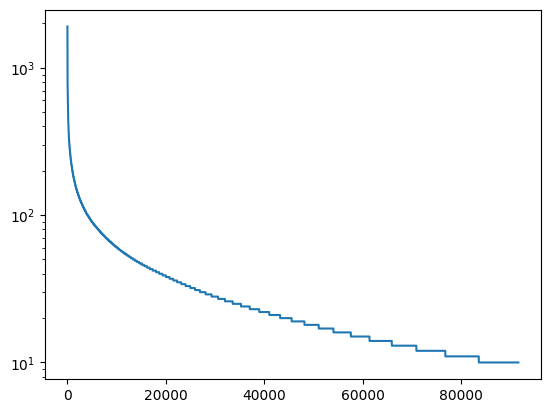


User distribution
count    52643.000000
mean        56.685751
std         96.863097
min         16.000000
25%         24.000000
50%         33.000000
75%         57.000000
95%        165.000000
99.9%      837.000000
max      13313.000000
Name: count, dtype: float64


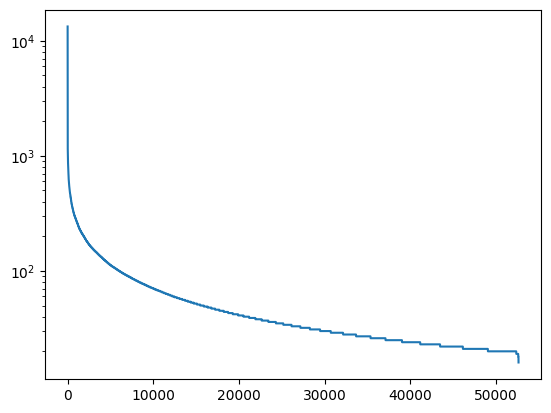


Creating dataset splits...


/var/folders/m5/9398ts6n79v025npdc_zn2x80000gn/T/ipykernel_49928/2456589156.py:296: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inputs_df = user_id_groups.apply(lambda x: x[target_sizes[x.name] :]).reset_index(
/var/folders/m5/9398ts6n79v025npdc_zn2x80000gn/T/ipykernel_49928/2456589156.py:299: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  target_df = user_id_groups.apply(lambda x: x[: target_sizes[x.name]

Done.


In [32]:
# 1.3. create Dataset object from the downloaded data.
# we will create an instance of AmazonBook Dataset (see `datasets/amazonbook.py`)
# for examples on how to create your own Dataset subclass, see `datasets/dataset.py` and other modules in `datasets`
# (implementation depends on 1. input data format, 2. preprocessing, 3. train-val-test split protocol)

dataset_config = {
    "name": "amazonbook",
    "rewrite": False,
}
dataset = Amazonbook.from_config(dataset_config)

clear_output()
print("Downloaded Amazon Books dataset.")
print("Dataset info:")
print(dataset.info())
print()

# 1.4. dataset statistics
# item_id histogram
item_id_counts = dataset.dataset.item_id.value_counts()
print("Item distribution")
print(item_id_counts.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.999]))
fig1 = plt.semilogy(np.arange(len(item_id_counts)), item_id_counts.values)
plt.show()
print()
# user_id histogram
user_id_counts = dataset.dataset.user_id.value_counts()
print("User distribution")
print(user_id_counts.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.999]))
fig2 = plt.semilogy(np.arange(len(user_id_counts)), user_id_counts.values)
plt.show()
print()

# 1.5. create dataset splits
# specify split configuration
split_config = {
    "seed": 42,
    "val_target_proportion": 0.0,
}

# create train, val, test sets
print("Creating dataset splits...")
train, val, test = dataset.create_splits(config=split_config)  # also transforms original item_ids to range(0,num_items)
print("Done.")

# 1.6. create ASIN <--> item_id mapping (to make this demo pretty :) )
np.testing.assert_array_equal(np.arange(91599), train.item_encoder.classes_)  # we won't need to map original item_ids <--> encoded item_ids


def get_asin_to_item_dicts(item_list_path):
    with open(item_list_path, "r") as f:
        lines = f.readlines()[1:]
    asin2item, item2asin = {}, {}
    for line in lines:
        a, i = tuple(line.strip().split(" "))
        if (a != "") and (i != ""):
            asin2item[a] = int(i)
            item2asin[int(i)] = a

    return asin2item, item2asin


item_list_path = dataset_path + "/item_list.txt"
asin2item, item2asin = get_asin_to_item_dicts(item_list_path)

# 2. Model training

In [33]:
from sansa import SANSA, SANSAConfig, ICFGramianFactorizerConfig, UMRUnitLowerTriangleInverterConfig


factorizer_config = ICFGramianFactorizerConfig(
    factorization_shift_step=1e-3,
    factorization_shift_multiplier=2.0,
)

inverter_config = UMRUnitLowerTriangleInverterConfig(
    scans=1,
    finetune_steps=5,
)


# create model instance from config
model_config = SANSAConfig(
    l2=20.0,
    weight_matrix_density=5e-5,
    gramian_factorizer_config=factorizer_config,
    lower_triangle_inverter_config=inverter_config,
)

model = SANSA(model_config)

user_item_matrix = df_to_csr(train.data, (train.n_users, train.n_items))

model.fit(training_matrix=user_item_matrix)

# model.fit(training_matrix=user_item_matrix.T @ user_item_matrix, compute_gramian=False)

INFO:sansa.model:Computing column norms of X^TX...
INFO:sansa.model:Scaling columns of X by computed norms...
INFO:sansa.model:Computing LDL^T decomposition of permuted item-item matrix...
INFO:sansa.core.factorizers:Computing incomplete Cholesky decomposition of X^TX + 20.0*I...
INFO:sansa.core.factorizers:Finding a fill-in reducing ordering (method = colamd)...
INFO:sansa.core.factorizers:Computing X^TX...
INFO:sansa.core.factorizers:
                X^TX info:
                    shape = (91599, 91599) 
                    nnz = 330335853 
                    density = 3.937080% 
                    size = 2643.1 MB
                
INFO:sansa.core.factorizers:Sorting indices of A...
INFO:sansa.core.factorizers:Casting indptr of A to int64...
INFO:sansa.core.factorizers:Casting indices of A to int64...
INFO:sansa.core.factorizers:Computing approximate Cholesky decomposition (method = ICF)...
INFO:sansa.core.factorizers:Scaling columns and creating diagonal matrix D (LL^T -> L'DL'^T)

# 3. Evaluation

In [34]:
from typing import Protocol


class Model(Protocol):
    def recommend(self, interactions: sp.csr_matrix, k: int, mask_input: bool) -> tuple[np.ndarray, np.ndarray]: ...


# Accuracy-based recommendation quality metrics
def recall(ids_true: np.ndarray, ids_top_k: np.ndarray) -> float:
    k = len(ids_top_k)
    num_true = len(ids_true)
    num_positive = np.sum(np.isin(ids_top_k, ids_true), dtype=np.float32)
    return num_positive / min(k, num_true)


# recall used by openbenchmark BARS
def recall_BARS(ids_true: np.ndarray, ids_top_k: np.ndarray) -> float:
    num_true = len(ids_true)
    num_positive = np.sum(np.isin(ids_top_k, ids_true), dtype=np.float32)
    return num_positive / num_true


def ndcg(ids_true, ids_top_k) -> float:
    k = len(ids_top_k)
    num_true = len(ids_true)
    relevances_top_k = np.isin(ids_top_k, ids_true).astype(np.float32)
    with np.errstate(divide="ignore"):  # can raise divide by zero warning when using intel MKL numpy. Most likely cause by endianness
        tp = 1.0 / np.log2(np.arange(2, k + 2))
    dcg = (relevances_top_k * tp).sum()
    idcg = tp[: min(num_true, k)].sum()
    return dcg / idcg


def get_stats(metrics: list[float]) -> dict:
    """
    Summary statistics of a list of metrics.
    """
    stats = {
        "mean": np.average(metrics),
        "se": np.std(metrics) / np.sqrt(len(metrics)),
    }
    return stats


def evaluate(
    model: Model,
    split: DatasetSplit,
    metrics: list[str] = ["recall", "ndcg"],
    ks: list[int] = [20, 50, 100],
    batch_size: int = 2000,
) -> dict[int : dict[str:dict]]:
    """
    Batched evaluation of a model on a split of a dataset.
    """
    stats = {
        k: {
            "coverage": 0.0,
        }
        for k in ks
    }
    max_k = max(ks)

    total_users = len(split.user_encoder.classes_)

    recalls = {k: [] for k in ks}
    recalls_BARS = {k: [] for k in ks}
    ndcgs = {k: [] for k in ks}

    for batch_start in range(0, total_users, batch_size):
        if batch_start + batch_size > total_users:
            batch_end = total_users
        else:
            batch_end = batch_start + batch_size
        print(f"Evaluating model at batch {batch_start}:{batch_end}")
        batch_users = list(split.user_encoder.classes_)[batch_start:batch_end]
        batch_data = split.get_rated_items(batch_users)
        batch_targets = split.get_target_items(batch_users)
        batch_target_ids_dict = batch_targets.groupby("user_id", group_keys=True)["item_id"].apply(list).to_dict()
        batch_keys = list(batch_target_ids_dict.keys())
        users_to_arange = {user: i for i, user in enumerate(batch_keys)}
        pd.options.mode.chained_assignment = None  # suppress irrelevant warning
        batch_data["user_id"] = batch_data["user_id"].map(users_to_arange)
        pd.options.mode.chained_assignment = "warn"
        batch_top_maxk_ids, batch_top_maxk_scores = model.recommend(df_to_csr(batch_data, (batch_end - batch_start, split.n_items)), k=max_k, mask_input=True)

        for k in ks:
            recalls_batch = []
            recalls_BARS_batch = []
            ndcgs_batch = []

            for i in range(len(batch_users)):
                target_ids = batch_target_ids_dict[batch_keys[i]]
                top_k_ids = batch_top_maxk_ids[i, :k]
                recalls_batch.append(recall(target_ids, top_k_ids))
                recalls_BARS_batch.append(recall_BARS(target_ids, top_k_ids))
                ndcgs_batch.append(ndcg(target_ids, top_k_ids))

            recalls[k] += recalls_batch
            recalls_BARS[k] += recalls_BARS_batch
            ndcgs[k] += ndcgs_batch

    for k in ks:
        if "recall" in metrics:
            stats[k]["recall"] = get_stats(metrics=recalls[k])
        if "recall BARS" in metrics:
            stats[k]["recall BARS"] = get_stats(metrics=recalls_BARS[k])
        if "ndcg" in metrics:
            stats[k]["ndcg"] = get_stats(metrics=ndcgs[k])

    return stats

In [35]:
metrics = ["recall BARS", "ndcg"]
ks = [20]
batch_size = 2000

evaluation_dict = evaluate(
    model=model,
    split=test,
    metrics=metrics,
    ks=ks,
    batch_size=batch_size,
)

clear_output()
for metric in metrics:
    for k in ks:
        print(f"{metric} @ {k}: {evaluation_dict[k][metric]['mean']:.5f} +- {evaluation_dict[k][metric]['se']:.5f}")

recall BARS @ 20: 0.07680 +- 0.00058
ndcg @ 20: 0.06372 +- 0.00050


# 4. Inference demo

In [36]:
np.random.seed(42)

## 4.0. "Sanity check" - Recommending for a user with mainstream taste

### Interactions

In [37]:
sample_user_id = 7  # Terry Pratcher, Steven King, Philip Pullman

# user's interactions
interaction_df = test.data[test.data.user_id == sample_user_id]
# translate item_ids to ASINS
interacted_item_ids, interacted_feedback = interaction_df.item_id.values, interaction_df.feedback.values
interacted_asins = np.vectorize(item2asin.get)(interacted_item_ids)

print("Interacted book ASINs")
print(interacted_asins)
print(len(interacted_asins))

# display sample of interactions
urls = []
asins = np.random.choice(interacted_asins, size=MAX_IMAGES, replace=False)
print("Sample interactions")
ipyplot.plot_images([url_pattern.replace("ASIN", asin) for asin in asins], labels=asins, img_width=IMG_WIDTH)

Interacted book ASINs
['0689110456' '039913297X' '0345311965' '067101675X' '0061091995'
 '0061020699' '0061020672' '0740704818' '0451167538' '0061020702'
 '0307743667' '0451161343' '0679643524' '067155302X' '0425194523'
 '0345413369' '0345413350' '0446600660' '0345338588']
19
Sample interactions


### Predictions


In [38]:
# run prediction for the user
k = 20

interaction_csr = sp.csr_matrix(
    (interacted_feedback, interacted_item_ids, [0, len(interacted_item_ids)]),
    shape=(1, train.n_items),
)

top_k_item_ids, top_k_scores = model.recommend(interactions=interaction_csr, k=k, mask_input=True)
top_k_item_ids, top_k_scores = top_k_item_ids.reshape(-1), top_k_scores.reshape(-1)
top_k_scores /= np.linalg.norm(top_k_scores)  # normalize score vector to unit length (optional)
# translate predicted item_ids to ASINS
top_k_asins = np.vectorize(item2asin.get)(top_k_item_ids)

# display predicted items
urls = []
asins = top_k_asins[:MAX_IMAGES_REC]
print()
print("Recommendations")
ipyplot.plot_images(
    [url_pattern.replace("ASIN", asin) for asin in asins],
    labels=[f"id: {i}, score: {s}" for i, s in list(zip(asins, top_k_scores))],
    img_width=IMG_WIDTH,
)


Recommendations


### Target items

In [39]:
# translate target item_ids to ASINS
target_item_ids = test.targets[test.targets.user_id == sample_user_id].item_id.values
target_asins = np.vectorize(item2asin.get)(target_item_ids)

# display target items
urls = []
asins = target_asins[:MAX_IMAGES]
print("Target items")
ipyplot.plot_images([url_pattern.replace("ASIN", asin) for asin in asins], labels=asins, img_width=IMG_WIDTH)

Target items


## 4.1. Recommending based on a single long-tail item

### Interaction

In [40]:
# sample a long-tail item
sample_item_id = np.random.choice(item_id_counts[-1000:].index.values)
sample_asin = item2asin[sample_item_id]
print("Sample long-tail item")
print(f"item_id: {sample_item_id}")
print(f"ASIN: {sample_asin}")
print(f"number of interactions: {item_id_counts[sample_item_id]}")
ipyplot.plot_images([url_pattern.replace("ASIN", sample_asin)], labels=[sample_asin], img_width=IMG_WIDTH)

# create input tuple of np.arrays
sample_item, sample_feedback = np.array([sample_item_id]), np.array([1.0])

Sample long-tail item
item_id: 9513
ASIN: 0451207319
number of interactions: 10


### Predictions

In [41]:
# predict based on this item
k = 20

sample_csr = sp.csr_matrix(
    (sample_feedback, sample_item, [0, len(sample_item)]),
    shape=(1, train.n_items),
)

top_k_item_ids, top_k_scores = model.recommend(interactions=sample_csr, k=k, mask_input=True)
top_k_item_ids, top_k_scores = top_k_item_ids.reshape(-1), top_k_scores.reshape(-1)
top_k_scores /= np.linalg.norm(top_k_scores)
# translate predicted item_ids to ASINS
top_k_asins = np.vectorize(item2asin.get)(top_k_item_ids)

# display predicted items
urls = []
asins = top_k_asins[:MAX_IMAGES_REC]
print("Recommendations")
ipyplot.plot_images(
    [url_pattern.replace("ASIN", asin) for asin in asins],
    labels=[f"id: {i}, score: {s}" for i, s in list(zip(asins, top_k_scores))],
    img_width=IMG_WIDTH,
)

Recommendations
